In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_data(df):
    """Preprocess data with validation checks"""
    # Verify sequences
    df['sequence'] = df['sequence'].astype(str).str.upper()
    valid_nucleotides = set('ATCG')
    df = df[df['sequence'].apply(lambda x: set(x).issubset(valid_nucleotides))]
    
    # Extract features
    features = pd.DataFrame({
        'length': df['sequence'].str.len(),
        'gc_content': df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) * 100),
        'a_freq': df['sequence'].apply(lambda x: x.count('A') / len(x)),
        't_freq': df['sequence'].apply(lambda x: x.count('T') / len(x)),
        'g_freq': df['sequence'].apply(lambda x: x.count('G') / len(x)),
        'c_freq': df['sequence'].apply(lambda x: x.count('C') / len(x))
    })
    
    # Generate k-mers
    df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))
    
    # Prepare sequence data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['kmers'])
    sequences = tokenizer.texts_to_sequences(df['kmers'])
    X_seq = pad_sequences(sequences, maxlen=500)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_num = scaler.fit_transform(features)
    
    # Combine features
    X = np.hstack((X_seq, X_num))
    
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Species'])
    
    return X, y, label_encoder

# Load data
df = pd.read_csv('momo.csv')  # Update path as needed
X, y, label_encoder = preprocess_data(df)

C:\Users\Dhruv\AppData\Local\Temp\ipykernel_3324\202360566.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def preprocess_data(df):
    """Preprocess data with validation checks"""
    # Verify sequences
    df['sequence'] = df['sequence'].astype(str).str.upper()
    valid_nucleotides = set('ATCG')
    df = df[df['sequence'].apply(lambda x: set(x).issubset(valid_nucleotides))]

    # Extract features
    features = pd.DataFrame({
        'length': df['sequence'].str.len(),
        'gc_content': df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) * 100),
        'a_freq': df['sequence'].apply(lambda x: x.count('A') / len(x)),
        't_freq': df['sequence'].apply(lambda x: x.count('T') / len(x)),
        'g_freq': df['sequence'].apply(lambda x: x.count('G') / len(x)),
        'c_freq': df['sequence'].apply(lambda x: x.count('C') / len(x))
    })

    # Generate k-mers
    df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))

    # Prepare sequence data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['kmers'])
    sequences = tokenizer.texts_to_sequences(df['kmers'])
    X_seq = pad_sequences(sequences, maxlen=500)

    # Scale numerical features
    scaler = StandardScaler()
    X_num = scaler.fit_transform(features)

    # Combine features
    X = np.hstack((X_seq, X_num))

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Species'])

    return X, y, label_encoder

def k_fold_cross_validation(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    print(f"Starting K-fold cross-validation with {k} splits...\n")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Processing fold {fold + 1}/{k}...")

        # Split data into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

        # Train the model
        model.fit(X_train, y_train)
        print(f"Fold {fold + 1}: Model trained.")

        # Make predictions and evaluate accuracy
        y_pred = model.predict(X_val)
        fold_accuracy = accuracy_score(y_val, y_pred)
        scores.append(fold_accuracy)

        print(f"Fold {fold + 1}: Accuracy = {fold_accuracy:.4f}")

    # Calculate average accuracy across all folds
    avg_accuracy = sum(scores) / k
    print(f"\nCross-validation completed. Average accuracy: {avg_accuracy:.4f}")

    return avg_accuracy, scores

# Load data
df = pd.read_csv('momo.csv')  # Update path as needed
X, y, label_encoder = preprocess_data(df)

# Initialize HistGradientBoosting model
print("Initializing HistGradientBoosting model...\n")
hgb_model = HistGradientBoostingClassifier(
    max_iter=50,       # Equivalent to n_estimators
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=20,
    random_state=42,
       # Utilize all CPU cores
)

# Perform K-fold cross-validation
print("Starting HistGradientBoosting model K-fold cross-validation...\n")
hgb_avg_accuracy, hgb_scores = k_fold_cross_validation(hgb_model, X, y, k=5)

# Output the results
print(f"\nHistGradientBoosting Average Accuracy: {hgb_avg_accuracy:.4f}")
print(f"HistGradientBoosting K-fold Scores: {hgb_scores}")


C:\Users\Dhruv\AppData\Local\Temp\ipykernel_3324\1432023667.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))


Initializing Gradient Boosting model...

Starting Gradient Boosting model K-fold cross-validation...

Starting K-fold cross-validation with 5 splits...

Processing fold 1/5...
Training data shape: (19510, 506), Validation data shape: (4878, 506)


KeyboardInterrupt: 

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from collections import Counter

def extract_kmers(sequence, k=3):
    """Efficiently extract k-mers using a generator"""
    return (sequence[i:i+k] for i in range(len(sequence)-k+1))

def preprocess_data(df, max_features=1000):
    """Optimized preprocessing with memory-efficient operations"""
    # Basic data validation
    print("Validating sequences...")
    df = df[df['sequence'].str.contains('^[ATCG]+$', regex=True)].copy()
    
    # Calculate sequence features efficiently
    print("Extracting basic sequence features...")
    sequences = df['sequence'].values
    lengths = np.vectorize(len)(sequences)
    
    # Vectorized operations for nucleotide frequencies
    features = pd.DataFrame({
        'length': lengths,
        'gc_content': df['sequence'].str.count('[GC]').values / lengths * 100,
        'a_freq': df['sequence'].str.count('A').values / lengths,
        't_freq': df['sequence'].str.count('T').values / lengths,
        'g_freq': df['sequence'].str.count('G').values / lengths,
        'c_freq': df['sequence'].str.count('C').values / lengths
    })
    
    # Efficient k-mer processing using Counter
    print("Processing k-mers...")
    all_kmers = Counter()
    for i, seq in enumerate(sequences):
        if i % 1000 == 0:
            print(f"Processing sequence {i}/{len(sequences)}")
        all_kmers.update(extract_kmers(seq))
    
    # Select top k-mers by frequency
    top_kmers = dict(sorted(all_kmers.items(), key=lambda x: x[1], reverse=True)[:max_features])
    kmer_indices = {kmer: idx for idx, kmer in enumerate(top_kmers)}
    
    # Create sparse k-mer matrix
    print("Creating k-mer feature matrix...")
    X_kmer = np.zeros((len(sequences), len(kmer_indices)))
    for i, seq in enumerate(sequences):
        if i % 1000 == 0:
            print(f"Processing sequence {i}/{len(sequences)}")
        seq_kmers = Counter(extract_kmers(seq))
        for kmer, count in seq_kmers.items():
            if kmer in kmer_indices:
                X_kmer[i, kmer_indices[kmer]] = count
    
    # Scale features
    print("Scaling features...")
    scaler = StandardScaler()
    X_num = scaler.fit_transform(features)
    
    # Combine features
    X = np.hstack((X_kmer, X_num))
    
    # Encode labels
    print("Encoding labels...")
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Species'])
    
    return X, y, label_encoder

def k_fold_cross_validation(model, X, y, k=5):
    """Standard k-fold cross validation"""
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    
    print(f"Starting K-fold cross-validation with {k} splits...")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Processing fold {fold + 1}/{k}")
        
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train model
        print(f"Training fold {fold + 1}...")
        model.fit(X_train, y_train)
        
        # Evaluate
        print(f"Evaluating fold {fold + 1}...")
        y_pred = model.predict(X_val)
        fold_accuracy = accuracy_score(y_val, y_pred)
        scores.append(fold_accuracy)
        print(f"Fold {fold + 1}: Accuracy = {fold_accuracy:.4f}")
    
    avg_accuracy = np.mean(scores)
    print(f"\nCross-validation completed. Average accuracy: {avg_accuracy:.4f}")
    return avg_accuracy, scores

# Main execution
if __name__ == "__main__":
    # Load data
    print("Loading data...")
    df = pd.read_csv('momo.csv')
    
    # Preprocess with reduced feature set
    print("Preprocessing data...")
    X, y, label_encoder = preprocess_data(df, max_features=500)
    
    # Initialize model
    print("Initializing Gradient Boosting model...")
    gb_model = GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=5,
        random_state=42
    )
    
    # Perform cross-validation
    print("Starting cross-validation...")
    gb_avg_accuracy, gb_scores = k_fold_cross_validation(gb_model, X, y, k=5)
    
    # Output results
    print(f"\nFinal Results:")
    print(f"Average Accuracy: {gb_avg_accuracy:.4f}")
    print(f"Individual Fold Scores: {[f'{score:.4f}' for score in gb_scores]}")

Loading data...
Preprocessing data...
Validating sequences...
Extracting basic sequence features...
Processing k-mers...
Processing sequence 0/24388
Processing sequence 1000/24388
Processing sequence 2000/24388
Processing sequence 3000/24388
Processing sequence 4000/24388
Processing sequence 5000/24388
Processing sequence 6000/24388
Processing sequence 7000/24388
Processing sequence 8000/24388
Processing sequence 9000/24388
Processing sequence 10000/24388
Processing sequence 11000/24388
Processing sequence 12000/24388
Processing sequence 13000/24388
Processing sequence 14000/24388
Processing sequence 15000/24388
Processing sequence 16000/24388
Processing sequence 17000/24388
Processing sequence 18000/24388
Processing sequence 19000/24388
Processing sequence 20000/24388
Processing sequence 21000/24388
Processing sequence 22000/24388
Processing sequence 23000/24388
Processing sequence 24000/24388
Creating k-mer feature matrix...
Processing sequence 0/24388
Processing sequence 1000/24388


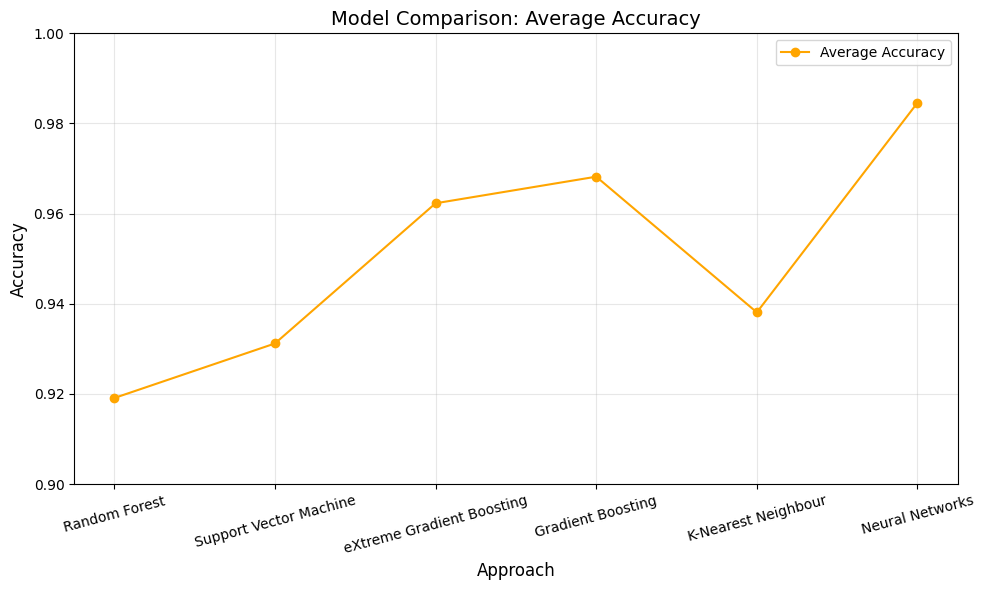

In [1]:
import matplotlib.pyplot as plt

# Data for plotting
approaches = [
    "Random Forest", 
    "Support Vector Machine", 
    "eXtreme Gradient Boosting", 
    "Gradient Boosting", 
    "K-Nearest Neighbour", 
    "Neural Networks"
]
accuracies = [
    0.9191, 
    0.9312, 
    0.9623, 
    0.9682, 
    0.9381, 
    0.9846
]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(approaches, accuracies, marker='o', linestyle='-', color='orange', label='Average Accuracy')

# Customizing the chart
plt.title('Model Comparison: Average Accuracy', fontsize=14)
plt.xlabel('Approach', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.9, 1.0)  # Set y-axis range for better visualization
plt.xticks(rotation=15, fontsize=10)
plt.grid(alpha=0.3)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
